In [1]:
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
from sys import stdout

import numpy as np
from joblib import Parallel, delayed
import pickle

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# load the PDB file containing the peptide information
pdb = PDBFile('proteins/test.pdb')
# initialize the forcefield and modeller
forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')
modeller = Modeller(pdb.topology, pdb.positions)
print(modeller.topology)

<Topology; 1 chains, 19 residues, 335 atoms, 338 bonds>


In [3]:
def get_index(name, atoms):
    return [atom for atom in atoms if atom.name == name][0].index

indices = []
for res in modeller.topology.residues():
    # get the chain indices of different atoms
    indices.append(dict(N=get_index('N', res.atoms()),
                        CA=get_index('CA', res.atoms()),
                        CB=get_index('CB', res.atoms()),
                        C=get_index('C', res.atoms())))

In [20]:
# define hyperparameters
k_start = 10
population_size = 7
n_survivors = 3
n_random = 1
n_residues = len(list(modeller.topology.residues()))

In [48]:
def evaluate(parameters, return_simulation=False):
    # initialize the system and integrator
    system = forcefield.createSystem(modeller.topology, nonbondedMethod=CutoffNonPeriodic, nonbondedCutoff=1*nanometer, constraints=HBonds)
    integrator = LangevinIntegrator(300*kelvin, 1/picosecond, 0.001*picoseconds)
    integrator.setRandomNumberSeed(534456)
    
    # construct the angle forces from the parameter set
    force = CustomAngleForce('k*(theta - theta0)^2')
    force.addPerAngleParameter('k')
    force.addPerAngleParameter('theta0')
    for prev in range(len(indices) - 2):
        curr = prev + 1
        next_ = curr + 1
        force.addAngle(indices[prev]['CA'],
                       indices[curr]['CA'],
                       indices[next_]['CA'],
                       (parameters[prev][0], parameters[prev][2]))
    angle_force_index = system.addForce(force)
    
    # construct the torsion forces from the parameter set
    force = CustomTorsionForce('k*(theta - theta0)^2')
    force.addPerTorsionParameter('k')
    force.addPerTorsionParameter('theta0')
    for prev in range(len(indices) - 1):
        curr = prev + 1
        force.addTorsion(indices[prev]['CA'],
                         indices[prev]['CB'],
                         indices[curr]['CA'],
                         indices[curr]['CB'],
                         (parameters[prev][1], parameters[prev][3]))
    torsion_force_index = system.addForce(force)

    # create the simulation
    simulation = Simulation(modeller.topology, system, integrator)
    simulation.context.setPositions(modeller.positions)
    simulation.minimizeEnergy()
    try:
        simulation.step(20000)
    except Exception as e:
        print(f'Simulation step failed: {e}')
        energy = np.inf * kilojoule/mole
        if return_simulation:
            # return the simulation object
            return simulation, energy
        return energy

    # remove the forces to get a realstic energy level
    simulation.system.removeForce(torsion_force_index)
    simulation.system.removeForce(angle_force_index)
    
    # compute the current potential energy
    energy = simulation.context.getState(getEnergy=True).getPotentialEnergy()
    
    if return_simulation:
        # return the simulation object
        return simulation, energy
    return energy

def random_params(count):
    ks = np.ones((count, n_residues - 1, 2)) * k_start
    thetas = np.random.uniform(0, 2 * np.pi, size=(count, n_residues - 1, 2))
    return np.concatenate((ks, thetas), axis=2)

def zero_k_params(count):
    ks = np.zeros((count, n_residues - 1, 2))
    thetas = np.random.uniform(0, 2 * np.pi, size=(count, n_residues - 1, 2))
    return np.concatenate((ks, thetas), axis=2)

In [22]:
# initialize the population
population = random_params(population_size)

In [7]:
with open('population.pickle', 'rb') as file:
    population = pickle.load(file)

In [23]:
def genetic_algorithm(survivor_params, count, mutation_rate=0.2):
    if count == 1:
        # perform crossover
        parents = np.random.permutation(len(survivor_params))[:2]
        params = np.array(survivor_params[parents[0]])
        crossover = np.random.uniform(size=params.shape) < 0.5
        params[crossover] = np.array(survivor_params[parents[1]][crossover])
        
        # get mutation for k parameter and apply mask
        k_mutation = np.random.normal(0, 5, size=(len(params), 2))
        k_mutation[np.random.uniform(size=k_mutation.shape)>mutation_rate] = 0
        
        # get mutation for theta parameter and apply mask
        theta_mutation = np.random.normal(0, 2 * np.pi, size=(len(params), 2))
        theta_mutation[np.random.uniform(size=theta_mutation.shape)>mutation_rate] = 0
        
        # add mutation to parameters
        params[:,:2] += k_mutation
        params[:,2:] += theta_mutation
        
        # apply constraint for k parameter
        params[:,:2][params[:,:2]<0] = 0
        return params
    else:
        #recursive call to generate single parameter sets
        return [genetic_algorithm(survivor_params, 1) for _ in range(count)]

# optimize the population for mutliple epochs
for i in range(10):
    # evaluate the population
    scores = Parallel(n_jobs=-1)(delayed(evaluate)(params) for params in population)
    population = population[np.argsort(scores)]
    # generate new random parameter sets
    population[n_survivors:n_survivors+n_random] = random_params(n_random)
    # run the genetic algorithm
    n_genetic_algorithm = population_size - n_survivors - n_random
    population[n_survivors+n_random:] = genetic_algorithm(population[:n_survivors], n_genetic_algorithm)
    print(f'({i + 1}) Min: {np.min(scores)}, Max: {np.max(scores)}')

(1) Min: 7400.689161786126 kJ/mol, Max: inf kJ/mol
(2) Min: 7083.909361583924 kJ/mol, Max: inf kJ/mol
(3) Min: 7880.044556311283 kJ/mol, Max: inf kJ/mol
(4) Min: 8125.537773226513 kJ/mol, Max: inf kJ/mol
(5) Min: 7238.884051142578 kJ/mol, Max: inf kJ/mol
(6) Min: 6970.0028388446635 kJ/mol, Max: inf kJ/mol
(7) Min: 7773.6256591433785 kJ/mol, Max: inf kJ/mol
(8) Min: 7458.487180953885 kJ/mol, Max: inf kJ/mol
(9) Min: 7708.781573977129 kJ/mol, Max: inf kJ/mol
(10) Min: 7438.925166045621 kJ/mol, Max: inf kJ/mol


In [57]:
# get the best parameter set and create a simulation from it
best_params = population[0]
best_sim, best_energy = evaluate(best_params, return_simulation=True)
print(f'Best energy: {best_energy}')

Best energy: 9027.40798033378 kJ/mol


In [14]:
with open('population.pickle', 'wb') as file:
    pickle.dump(population, file)

<IPython.core.display.Javascript object>


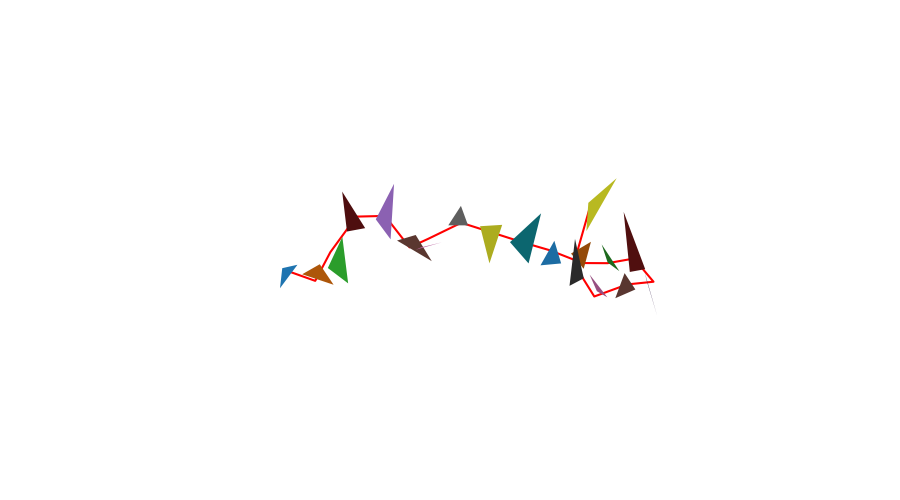

In [58]:
def draw_chain_atoms(residue_chain, positions, side_chain_viz='surface', aa_orientation=False):
    residue_chain = list(residue_chain)
    atoms = [np.array([positions[atom.index]._value for atom in res.atoms() if atom.name not in ['CA', 'N', 'C']]) for res in residue_chain]
    ca_atoms = np.array(sum([[positions[atom.index]._value for atom in res.atoms() if atom.name == 'CA'] for res in residue_chain]))
    c_atoms = np.array(sum([[positions[atom.index]._value for atom in res.atoms() if atom.name == 'C'] for res in residue_chain]))
    n_atoms = np.array(sum([[positions[atom.index]._value for atom in res.atoms() if atom.name == 'N'] for res in residue_chain]))
    aa_dir = c_atoms - n_atoms
    
    fig = plt.figure(figsize=(9, 5))
    ax = fig.add_subplot(111, projection='3d')
    cols = []
    for i, res_atoms in enumerate(atoms):
        col = ax.scatter(res_atoms[:,0], res_atoms[:,1], res_atoms[:,2], alpha=0).get_facecolor()
        cols.append(col[0])
        avg_side_pos = res_atoms.mean(axis=0)
        
        if side_chain_viz == 'arrow':
            side_dir = avg_side_pos - ca_atoms[i]
            ax.quiver(ca_atoms[i,0], ca_atoms[i,1], ca_atoms[i,2], side_dir[0], side_dir[1], side_dir[2], colors=col, alpha=0.6)
        elif side_chain_viz == 'surface':
            ax.plot_trisurf([n_atoms[i,0], avg_side_pos[0], c_atoms[i,0]], [n_atoms[i,1], avg_side_pos[1], c_atoms[i,1]], [n_atoms[i,2], avg_side_pos[2], c_atoms[i,2]])
        elif side_chain_viz is not None:
            print(f'Side chain visualization "{side_chain_viz}" unknown')
    
    ax.plot(ca_atoms[:,0], ca_atoms[:,1], ca_atoms[:,2], c='red')
    if aa_orientation:
        ax.quiver(n_atoms[:,0], n_atoms[:,1], n_atoms[:,2], aa_dir[:,0], aa_dir[:,1], aa_dir[:,2], colors='black', linewidth=2)

    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
# plot the protein structure
positions = best_sim.context.getState(getPositions=True).getPositions(asNumpy=True)
draw_chain_atoms(modeller.topology.residues(), positions)

In [16]:
# save the protein structure to a file
with open('proteins/ga_folding.pdb', 'w') as file:
    PDBFile.writeModel(best_sim.topology, best_sim.context.getState(getPositions=True).getPositions(), file=file)